In [19]:
import numpy as np
from scipy.stats import linregress

def rudimentary_multistep_waiting_times(signal, time, step_height, tolerance, start_value=None,output_stepfit=True,plotName='stepFitOutput'):
    """
    Detects waiting times where the signal stays within a band of width 2*tolerance,
    with bands spaced by step_height, starting from start_value (or min(signal) if None).
    The number of bands is determined by the signal's min and max values.

    Parameters:
        signal (np.ndarray): 1D array of signal values.
        time (np.ndarray): 1D array of time values (same length as signal).
        step_height (float): The target step height to define bands.
        tolerance (float): Allowed deviation from the band center.
        start_value (float or None): Center of the first band. If None, uses min(signal).

    Returns:
        waiting_times (list): List of waiting times (float) for each band visit.
        band_indices (list): List of (start_idx, end_idx, band_center) for each waiting time.
        fig (matplotlib.figure.Figure): The plot figure object.
    """
    import matplotlib.pyplot as plt

    signal = np.asarray(signal)
    time = np.asarray(time)
    waiting_times = []
    band_indices = []

    if start_value is None:
        base = np.min(signal)
    else:
        base = start_value

    max_val = np.max(signal)
    n_bands = int(np.ceil((max_val - base) / step_height)) + 1
    band_centers = [base + i * step_height for i in range(n_bands)]

    idx = 0
    n = len(signal)
    while idx < n:
        # Find which band the current value is in
        for band_center in band_centers:
            if abs(signal[idx] - band_center) <= tolerance:
                # Entered a band, now find how long it stays in this band
                start_idx = idx
                while idx < n and abs(signal[idx] - band_center) <= tolerance:
                    idx += 1
                end_idx = idx - 1
                waiting_time = time[end_idx] - time[start_idx]
                waiting_times.append(waiting_time)
                band_indices.append((start_idx, end_idx, band_center))
                break
        else:
            idx += 1

    # If only one band is detected, return NaN for waiting times and band indices
    if len(waiting_times) == 1:
        waiting_times = [np.nan]

    if len(waiting_times) > 1:
        #ignore the last waiting time because no event is detected at the tail of the signal
        waiting_times = waiting_times[:-1]

    # Linear fit and R^2 calculation (print only, do not modify plotting)
    # if len(waiting_times) > 1:
    x = np.arange(len(time))
    y = np.array(signal)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print(f"Linear fit R^2: {r_value**2:.4f}")

    if output_stepfit:
    # Plotting
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(time, signal, label='Signal')
        colors = plt.cm.viridis(np.linspace(0, 1, n_bands))
        for i, (start_idx, end_idx, band_center) in enumerate(band_indices):
            ax.axvspan(time[start_idx], time[end_idx], color=colors[i % n_bands], alpha=0.2)
            ax.axhspan(band_center - tolerance, band_center + tolerance, color=colors[i % n_bands], alpha=0.15)
            ax.axhline(band_center, color=colors[i % n_bands], linestyle='--', alpha=0.5)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('Signal')
        ax.set_title('Waiting Times in Bands (step_height={}, tolerance={})'.format(step_height, tolerance))
        ax.legend()
        plt.tight_layout()
        # plt.show()
        plt.savefig(plotName)

    return waiting_times, band_indices, fig

def parse_general_txt(filepath):
    data = {}
    # key_value_pattern = re.compile(r'^(\w[\w\s\[\]]*):\s*(.+)$')
    key_value_pattern = re.compile(r'^(.*?):\s*(.+)$')

    with open(filepath, 'r') as file:
        current_key = None
        current_value = ''
        for line in file:
            line = line.strip()
            if not line:
                continue

            match = key_value_pattern.match(line)
            if match:
                # Store the previous key-value pair
                if current_key is not None:
                    data[current_key] = process_value(current_value)

                # Start new key-value pair
                current_key = match.group(1).strip()
                current_value = match.group(2).strip()
            else:
                # Continue accumulating multi-line value
                if current_key is not None:
                    current_value += ' ' + line

        # Catch the last key-value pair
        if current_key is not None:
            data[current_key] = process_value(current_value)

    return data

def process_value(value_str):
    # Handle np.float64(...) wrappers
    value_str = re.sub(r'np\.float64\(([0-9.eE+-]+)\)', r'\1', value_str)

    # Try to convert to float or int
    try:
        return float(value_str)
    except ValueError:
        pass

    try:
        return int(value_str)
    except ValueError:
        pass

    # Try to convert to list of floats if possible
    if value_str.startswith('[') and value_str.endswith(']'):
        # Remove brackets
        value_str = value_str[1:-1]
        # Find all floats
        numbers = re.findall(r'[+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?', value_str)
        return [float(num) for num in numbers]

    return value_str  # Return raw string if nothing else applies

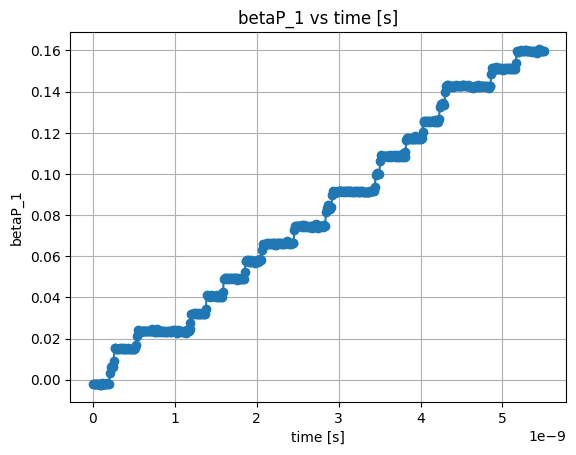

In [20]:
import os
import re
import numpy as np

# from rateCalibration import rudimentary_multistep_waiting_times

os.chdir('/mnt/c/Users/liamm/OneDrive/Desktop/UQ/calibration/DDD/screw/screwStepFit')
import matplotlib.pyplot as plt


data=parse_general_txt('results_seed_0_row_4.txt')

# Plot
plt.figure()
plt.plot(data['time [s]'], data['betaP_1'], marker='o')
plt.xlabel('time [s]')
plt.ylabel('betaP_1')
plt.title('betaP_1 vs time [s]')
plt.grid(True)
plt.show()

Linear fit R^2: 0.9913


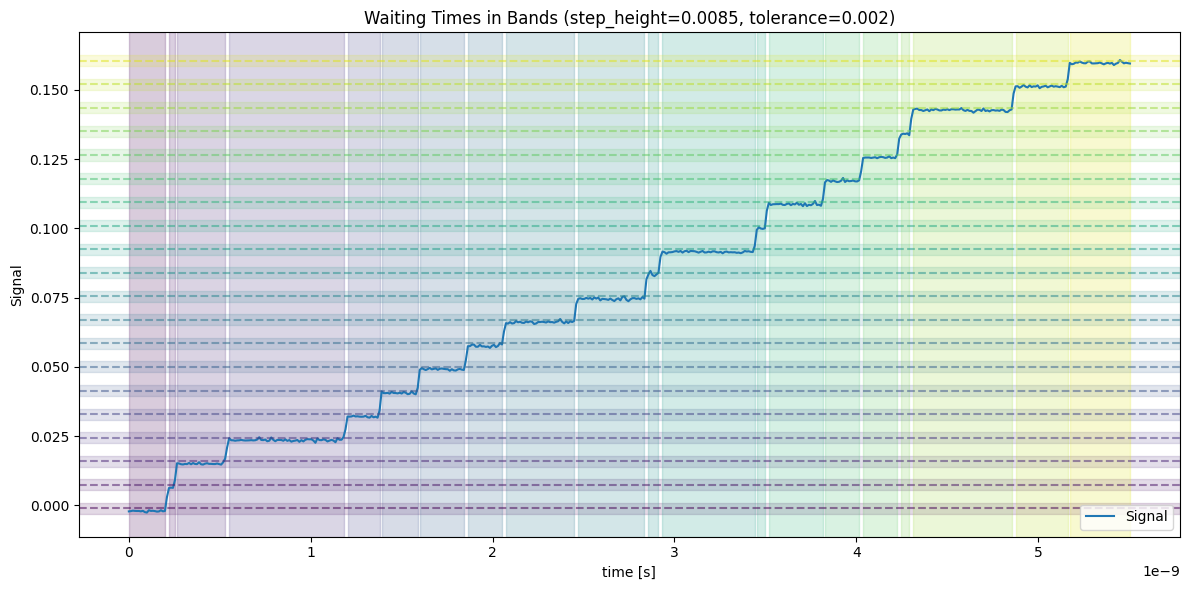

In [21]:
step_height = 0.0085
tolerance = 0.002
start_value = -0.001

waiting_times, step_indices, fig = rudimentary_multistep_waiting_times(
    data['betaP_1'],
    data['time [s]'],
    step_height=step_height,
    tolerance=tolerance,
    start_value=start_value,
    output_stepfit=True,
    plotName='step_detection_seed_0_row_4.png'
)

Linear fit R^2: 0.9996


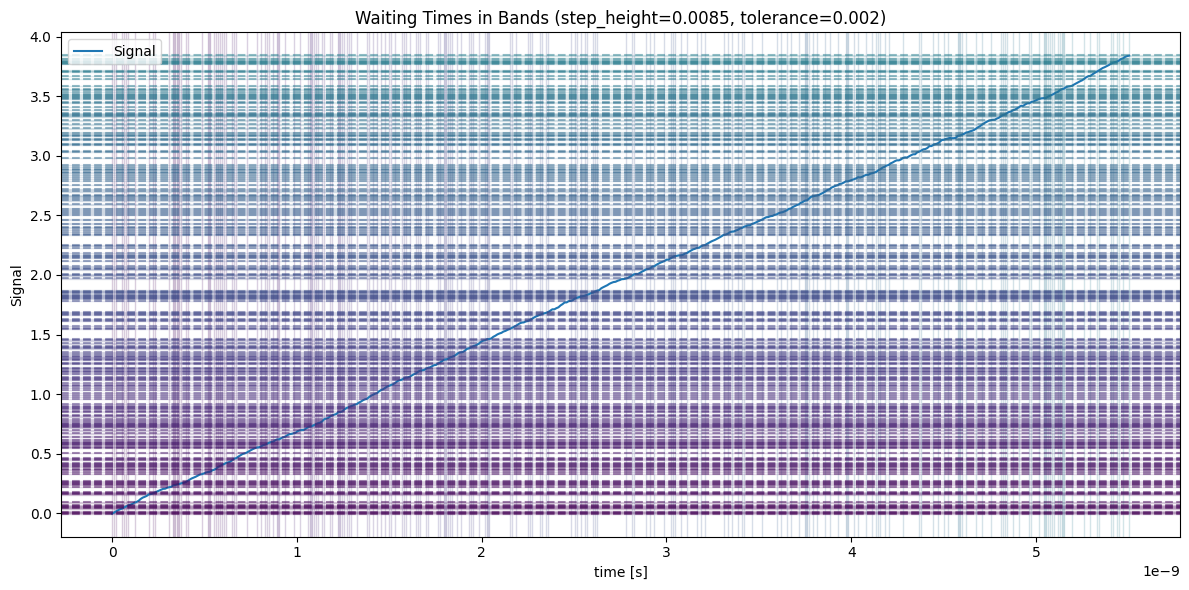

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

row_42_seed_0_dir="/mnt/c/Users/liamm/OneDrive/Desktop/UQ/calibration/DDD/filtering"
os.chdir(row_42_seed_0_dir)
data2=parse_general_txt('results_seed_0_row_42.txt')
waiting_times, step_indices, fig = rudimentary_multistep_waiting_times(
    data2['betaP_1'],
    data2['time [s]'],
    step_height=step_height,
    tolerance=tolerance,
    start_value=start_value,
    output_stepfit=True,
    plotName='step_detection_seed_0_row_4.png'
)

Linear fit R^2: 0.0374


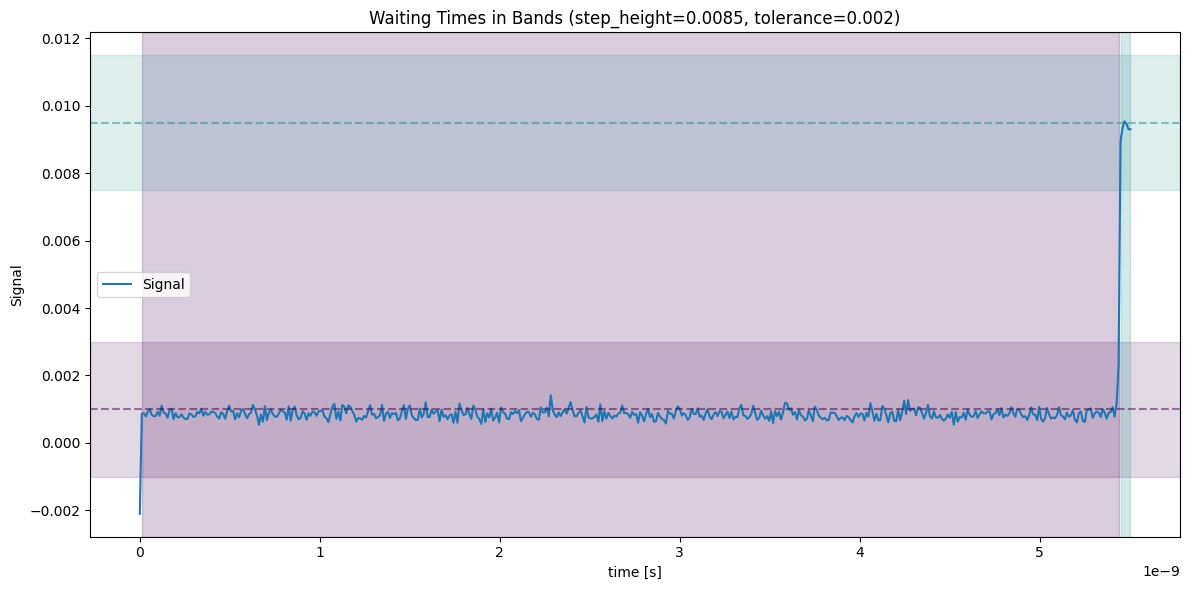

In [23]:
start_value=0.001
row_44_seed_0_dir="/mnt/c/Users/liamm/OneDrive/Desktop/UQ/calibration/DDD/filtering"
os.chdir(row_44_seed_0_dir)
data3=parse_general_txt('results_seed_0_row_44.txt')
waiting_times, step_indices, fig = rudimentary_multistep_waiting_times(
    data3['betaP_1'],
    data3['time [s]'],
    step_height=step_height,
    tolerance=tolerance,
    start_value=start_value,
    output_stepfit=True,
    plotName="row_44_seed_0_step_detection.png"
)